Emotion Detection Model

In [2]:
#Importing the necessary Libraries
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator   
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version : ", tf.__version__)

Tensorflow version :  2.13.0


Exploring Dataset

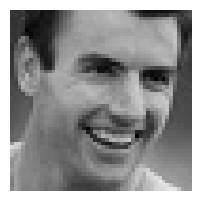

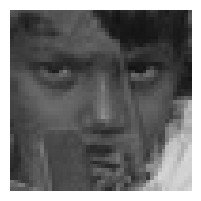

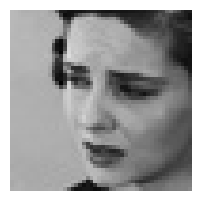

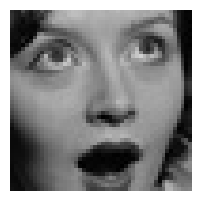

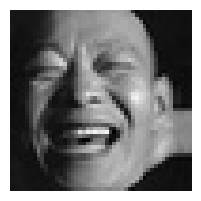

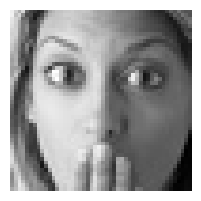

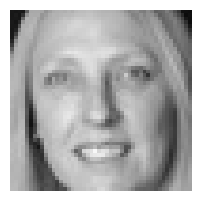

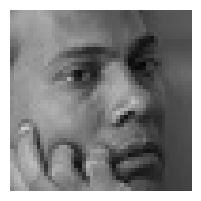

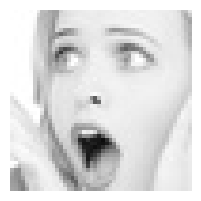

In [8]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(8,8))
    plt.subplot(330+1)
    plt.imshow(cv2.imread(image));plt.axis('off')


Preparing Data For Training

In [24]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",target_size = (img_size,img_size),
                                                             color_mode = "grayscale",
                                                             batch_size = batch_size,
                                                             class_mode = "categorical",
                                                             shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("train/",target_size = (img_size,img_size),
                                                             color_mode = "grayscale",
                                                             batch_size = batch_size,
                                                             class_mode = "categorical",
                                                             shuffle = True)



Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


Defining The Model

In [9]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [10]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [11]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [23]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

Initializing the Model

In [25]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weight.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose=1)
callbacks = [checkpoint]

Training The Model

In [26]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks
)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6870 - accuracy: 0.3563
Epoch 1: saving model to model_weight.h5
448/448 [==============================] - 916s 2s/step - loss: 1.6870 - accuracy: 0.3563 - val_loss: 1.4805 - val_accuracy: 0.4334
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4043 - accuracy: 0.4618
Epoch 2: saving model to model_weight.h5
448/448 [==============================] - 206s 459ms/step - loss: 1.4043 - accuracy: 0.4618 - val_loss: 1.2796 - val_accuracy: 0.5196
Epoch 3/15
 54/448 [==>...........................] - ETA: 2:35 - loss: 1.2904 - accuracy: 0.5061

KeyboardInterrupt: 

Model Evaluation

In [27]:
model.evaluate(validation_generator)

449/449 [==============================] - 43s 96ms/step - loss: 1.2825 - accuracy: 0.5052


[1.2824960947036743, 0.5052074193954468]

Plotting Loss

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.)

NameError: name 'history' is not defined

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.2)

NameError: name 'history' is not defined

Saving Model

In [31]:
model_json = model.to_json()
with open("model_a.json","w")as json_file:
    json_file.write(model_json)